## Peri-event graphs for trace fear conditioning

This notebook and accompanying code runs the analysis of z scored fiber photometry traces for our study:
> Rawlinson, E. C., McCullough, M. H., Marighetto, A., Al Abed, A. S., & Dehorter, N. (2024). Maladaptation of Memory Systems Impairs Dorsal CA1-Dependent Temporal Binding and Declarative Memory in The Cntnap2 Knockout Mouse Model of Autism. bioRxiv, 2024.2010.2029.620866. doi:10.1101/2024.10.29.620866

Please see our paper for details of our experimental methods, and refer to the README for further details about this research project, how to cite this code, and information on how to download the experimental data.

## INDEX
- [Preamble](#Preamble)
    - [Import statements](#Import-statements)
    - [Set environment](#Set-environment)
    - [Import data](#Import-data)
- **Figure 2**: Altered calcium responses during fear conditioning and recall in Cntnap2 KO
    - [Plotting](#Plotting)
    - [Print data into excel file for statistical analysis](#Print-data-into-excel-file-for-statistical-analysis)

# Preamble

## Import statements

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from tqdm.notebook import trange, tqdm

## Set environment

In [3]:
#Input name of experiment and corresponding tag used for data files for import and exports
experiment = 'Tone test'
tag = 'TFtt'

In [4]:
# Set paths
data_path = Path(f'Data/{experiment}/Z scores')
timings_path = Path(f'Data/{experiment}/{experiment} timings')
#timings_path = Path('/mnt/scratch/fiberphotometry/Behaviour data files for perievents plots/Conditioning')

fig_path = Path(f"figs/{experiment}/Peri-event plots")
if not fig_path.exists():
    fig_path.mkdir()

file_path = Path('files/TFC peri-events')

## Import data

In [5]:
def get_timings(m):
    # Returns the timings for tones and shocks for a given mouse
    TRIGGER = 6
    TONE = 20
    SHOCK = 4
    files = list(timings_path.glob(f"{m}*.dat"))
    if len(files) == 0:
        return [],[]
    else:
        file_path = files[0]
        timings = pd.read_csv(file_path, sep="\t", header=13, usecols=[0,1,2], names=["ts", "e1", "e2"])

    # Filter to keep only trigger events
    filter = (timings["e1"] == TRIGGER)
    timings = timings[filter]

    # Get timings for each
    tones = []
    shocks = []
    for i in range(0,len(timings),2):
        if timings["e2"].iloc[i] == SHOCK:
            shocks.append(tuple(timings["ts"].iloc[i:i+2].to_list()))

        elif timings["e2"].iloc[i] == TONE:
            tones.append(tuple(timings["ts"].iloc[i:i+2].to_list()))
    return tones, shocks

In [ ]:
def read_data(mouse_id):
    # Imports for list of mouse ids and returns a dataframe
    # Create dataframe
    df = pd.DataFrame(columns=["t", "dCA1", "mouse_type","tones","shocks"], index=mouse_id)

    # Import data and populate dataframe
    for m in mouse_id:
        file_path = data_path / f"{m}_{tag}_470nm-norm-zs.csv"
        if file_path.exists():
            fp_data = pd.read_csv(file_path)
            fp_data['time_aligned'] = fp_data['ComputerTimestamp'] - fp_data['ComputerTimestamp'].iloc[0] + 10000 # CHECK THIS MAGIC NUMBER
            t = fp_data['time_aligned'].values
            dCA1 = fp_data["dCA1"].values
            if "895" in m:
                mouse_type = "WT"
            elif "1079" in m:
                mouse_type = "KO"

            tones, shocks = get_timings(m)
            # convert tones and shocks to sample indices
            tones = [(np.argmin(np.abs(t - tone[0])), np.argmin(np.abs(t - tone[1]))) for tone in tones]
            shocks = [(np.argmin(np.abs(t - shock[0])), np.argmin(np.abs(t - shock[1]))) for shock in shocks]
            df.loc[m] = [t, dCA1, mouse_type,tones,shocks]
    
    # Truncate the time series to the length of the shortest one
    min_len = df['t'].apply(len).min()
    for m in mouse_id:
        df.loc[m, 't'] = df.loc[m, 't'][:min_len]
        df.loc[m, 'dCA1'] = df.loc[m, 'dCA1'][:min_len]

    return df

In [15]:
#array of mouse ids to be used for experiment
mouse_id = ["20231220-ASD895-305", "20231220-ASD895-306", "20231220-ASD895-308", "20231220-ASD895-309", "20231220-ASD895-310","20231220-ASD1079-16", "20231220-ASD1079-17","20231220-ASD1079-18", "20231220-ASD1079-19", "20231220-ASD1079-21", "20240508-ASD895-51",  "20240508-ASD895-49",  "20240508-ASD895-45",  "20240508-ASD895-44",  "20240508-ASD895-41","20240508-ASD895-40", "20240508-ASD1079-132","20240508-ASD1079-131","20240508-ASD1079-125", "20240508-ASD1079-124", "20240508-ASD1079-123", "20240508-ASD1079-122"]

#import data
df = read_data(mouse_id)

df

,t,dCA1,mouse_type,tones,shocks
20231220-ASD895-305,"[10000.0, 10032.980499997735, 10066.9602000042...","[-0.1520495191058931, -0.1937466408010643, -0....",WT,"[(3300, 6900)]",[]
20231220-ASD895-306,"[10000.0, 10032.981000006199, 10065.9620999991...","[-0.138715581815952, -0.3270014989836394, -0.0...",WT,"[(3300, 6900)]",[]
20231220-ASD895-308,"[10000.0, 10033.980400003493, 10066.9618000015...","[-0.3549835411966299, -0.4963620618845608, -0....",WT,"[(3300, 6901)]",[]
20231220-ASD895-309,"[10000.0, 10033.980800002813, 10067.9614000022...","[-0.2409489460367269, -0.2500267298071887, -0....",WT,"[(3300, 6899)]",[]
20231220-ASD895-310,"[10000.0, 10033.989299997687, 10066.9615999981...","[0.0581363772004781, 0.0693810674641467, 0.076...",WT,"[(3300, 6900)]",[]
20231220-ASD1079-16,"[10000.0, 10032.981499999762, 10065.9619999974...","[0.4870375405809473, 0.3413785420705382, 0.378...",KO,"[(3300, 6901)]",[]
20231220-ASD1079-17,"[10000.0, 10032.98070000112, 10066.96209999919...","[-0.7078960932873544, -0.7205610442274895, -0....",KO,"[(3300, 6900)]",[]
20231220-ASD1079-18,"[10000.0, 10032.980200000107, 10066.9609000012...","[1.38261330458592, 1.4030723900613342, 1.48948...",KO,"[(3300, 6901)]",[]
20231220-ASD1079-19,"[10000.0, 10032.98220000416, 10066.96190000325...","[3.8837431766694697, 3.452292379636336, 3.7813...",KO,"[(3300, 6901)]",[]
20231220-ASD1079-21,"[10000.0, 10032.979699999094, 10066.9603999927...","[0.1404330149804627, 0.4160355033950232, 0.673...",KO,"[(3300, 6901)]",[]


In [16]:
def get_events(df,event_type,event_index='all',pre=0,post=0,grp=None):
    ''' Returns the data for a given event type and genotype
    Inputs:
    df: dataframe
    event_type: string, name of the event ('tones' or 'shocks')
    event_index: index of the event to extract (i.e., tone 1, 2 or 3; default: all)
    pre: int, number of samples before the event to consider
    post: int, number of samples after the event to consider
    grp: string, genotype to consider (default: None)

    Returns:
    x: np.array, array of shape (n_events, pre+post), where n_events is the number of events
        extracted over all mice meeting the grp condition

    '''
    x = []
    IDs = []
    for m in df.index:

        if grp and (df.loc[m,'mouse_type'] != grp):
            continue
        if event_index == 'all':
            idx = np.arange(len(df.loc[m,event_type]))
        else:
            idx = [event_index-1]
        for i in idx:
            n0 = df.loc[m,event_type][i][0] - pre
            n1 = df.loc[m,event_type][i][0] + post
            x.append(df.loc[m,"dCA1"][n0:n1])
            IDs.append(df.loc[m])
    x = np.vstack(x)
    return x

# Plotting

In [17]:
def get_sem(data):
    return data.std(axis=0) / np.sqrt(data.shape[0])

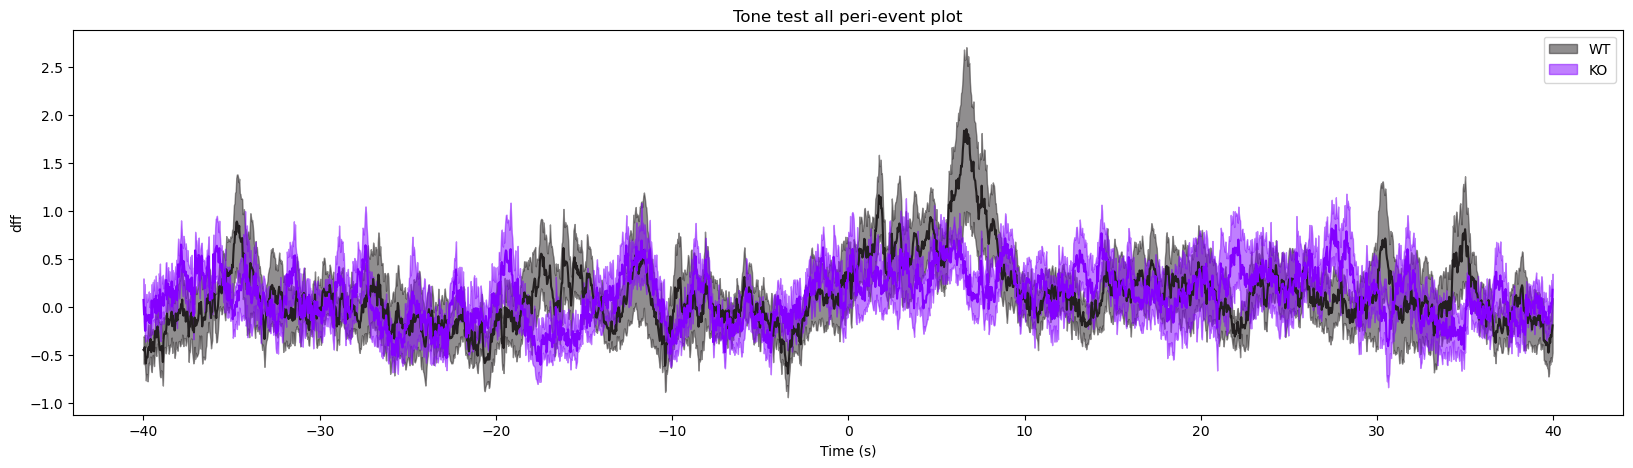

In [ ]:
#Set up plot
fig, ax = plt.subplots(figsize=(20,5))
#Define time points to be taken pre and post event of interest
pre = 1200
post = 1200

# Conversion factor to seconds
conversion_factor = 0.03333333333333333333333333333333333333333333333333333333333

# Choose what to analyse (tone or shock), and which instance (index starts at 1 - 1,2,3 or 'all')
event_type = 'tones'
event_index = 'all'

x = get_events(df, event_type, pre=pre, post=post, grp='WT', event_index=event_index)
time_points = np.arange(-pre, post) * conversion_factor
ax.plot(time_points, x.mean(axis=0), color='#231F20')
ax.fill_between(time_points, x.mean(axis=0) - get_sem(x), x.mean(axis=0) + get_sem(x), color='#231F20', alpha=0.5, label='WT')

ax.set_xlabel('Time (s)')
ax.set_ylabel('dff')
x = get_events(df, event_type, pre=pre, post=post, grp='KO', event_index=event_index)
ax.plot(time_points, x.mean(axis=0), color='#8300FF')
ax.fill_between(time_points, x.mean(axis=0) - get_sem(x), x.mean(axis=0) + get_sem(x), color='#8300FF', alpha=0.5, label='KO')
ax.legend()
ax.title.set_text(f'{experiment} {event_index} peri-event plot')

# Save
fig.savefig(fig_path / f"{experiment} {event_type} {event_index}.pdf")

plt.show()

## Print data into excel file for statistical analysis

Text(0.5, 1.0, 'Tone test tones all(WT)')

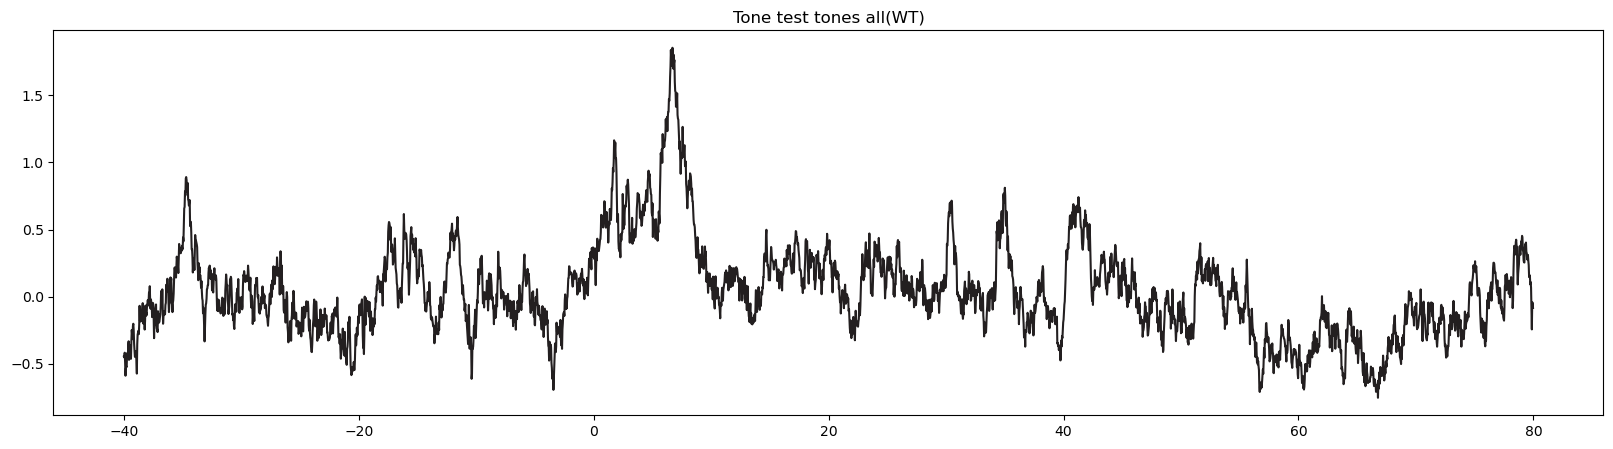

In [27]:
##WT

pre = 1200
post = 2400

time_range = post + pre
# Conversion factor to seconds
conversion_factor = 0.03333333333333333333333333333333333333333333333333333333333

# Choose tone (index starts at 1)
event_type = 'tones'
event_index = 'all'

x = get_events(df, event_type, pre=pre, post=post, grp='WT', event_index=event_index)
time_points = np.arange(-pre, post) * conversion_factor

WT_IDs = df.index[df['mouse_type'] == 'WT']

df_output = pd.DataFrame(x, columns=time_points, index=WT_IDs)
df_output

# Save
df_output.to_excel(file_path / f"{experiment} {event_type} {event_index} (WT).xlsx")

#Graph to make sure
fig, ax = plt.subplots(figsize=(20,5))
# Compute the mean response across all mice for each time point
mean_response = df_output.mean()
ax.plot(df_output.columns, mean_response, color='#231F20')
ax.set_xlabel = 'Time (s)'
ax.set_ylabel = 'dFf'
ax.set_title(f'{experiment} {event_type} {event_index}(WT)')

Text(0.5, 1.0, 'Tone test tones all (KO)')

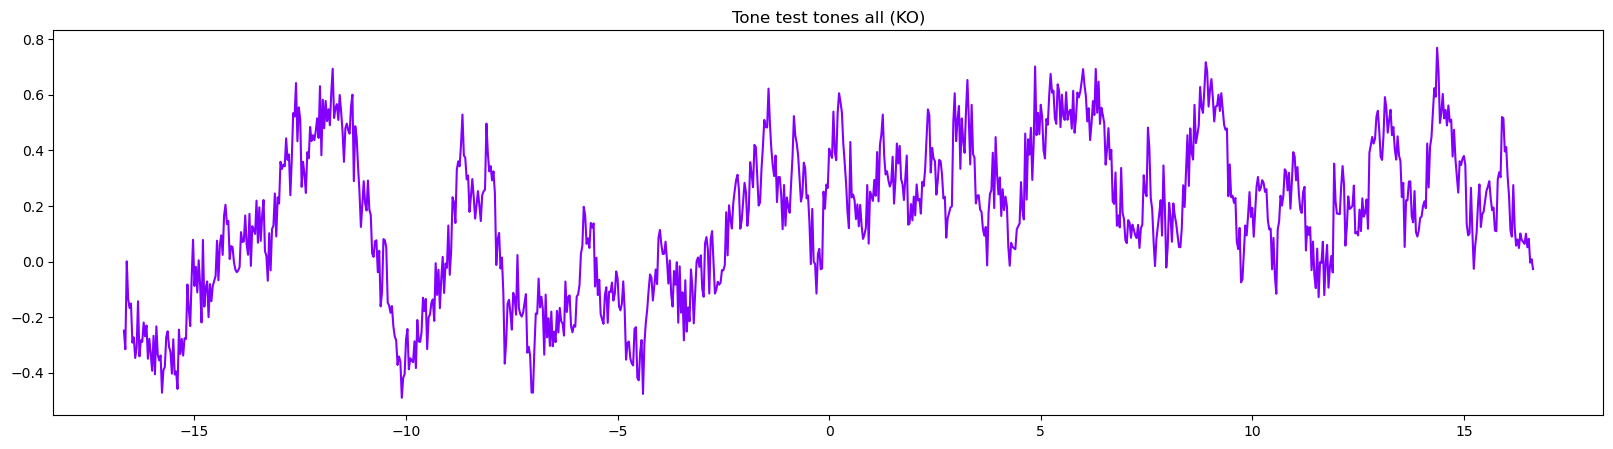

In [28]:
##KO

pre = 500
post = 500

time_range = post + pre
# Conversion factor to seconds
conversion_factor = 0.03333333333333333333333333333333333333333333333333333333333

# Choose tone (index starts at 1)
event_type = 'tones'
event_index = 'all'

x = get_events(df, event_type, pre=pre, post=post, grp='KO', event_index=event_index)
time_points = np.arange(-pre, post) * conversion_factor

KO_IDs = df.index[df['mouse_type'] == 'KO']

df_output = pd.DataFrame(x, columns=time_points, index=KO_IDs)
df_output

# Save
df_output.to_excel(file_path / f"{experiment} {event_type} {event_index} (WT).xlsx")

#Graph to make sure
fig, ax = plt.subplots(figsize=(20,5))
# Compute the mean response across all mice for each time point
mean_response = df_output.mean()
ax.plot(df_output.columns, mean_response, color='#8300FF')

ax.set_xlabel = 'Time (s)'
ax.set_ylabel = 'dFf'
ax.set_title(f'{experiment} {event_type} {event_index} (KO)')